In [1]:
!pip install fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import fastbook
fastbook.setup_book()

In [3]:
import torch
from pathlib import Path
import pandas as pd
from PIL import Image
import torchvision.models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

train_df = pd.read_csv(Path('/kaggle/input/paddy-disease-classification/train.csv'))
train_df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [4]:
def get_image_path(row):
    return f"/kaggle/input/paddy-disease-classification/train_images/{row['label']}/{row['image_id']}"

train_df['image_path'] = train_df.apply(get_image_path, axis=1)
train_df.head()

,image_id,label,variety,age,image_path
0,100330.jpg,bacterial_leaf_blight,ADT45,45,/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100330.jpg
1,100365.jpg,bacterial_leaf_blight,ADT45,45,/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100365.jpg
2,100382.jpg,bacterial_leaf_blight,ADT45,45,/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100382.jpg
3,100632.jpg,bacterial_leaf_blight,ADT45,45,/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100632.jpg
4,101918.jpg,bacterial_leaf_blight,ADT45,45,/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/101918.jpg


In [63]:
# Value counts
train_df['label'].value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

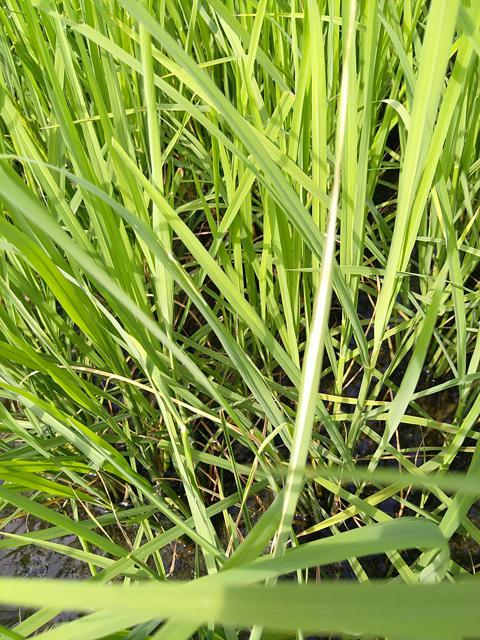

In [6]:
# Let's look at a few images
image = Path('/kaggle/input/paddy-disease-classification/train_images/bacterial_leaf_blight/100023.jpg')
Image.open(image)

In [7]:
# Put all labels and images into different lists

image_paths = train_df['image_path'].to_list()
labels = train_df['label'].to_list()

In [31]:
from sklearn.preprocessing import LabelEncoder

# We need to encode the labels using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [12]:
# # Let's see the sizes of the images
# from fastcore.parallel import *

# def f(o): 
#     return PILImage.create(o).size

# sizes = parallel(f, image_paths, n_workers=8)
# pd.Series(sizes).value_counts()

In [32]:
# Quick iteration without data augmentation
class PaddyDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx])
        image = Image.open(image).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [38]:
from sklearn.model_selection import train_test_split

simple_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images, valid_images, train_categories, valid_categories = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PaddyDataset(train_images, train_categories, transforms=simple_transforms)
valid_dataset = PaddyDataset(valid_images, valid_categories, transforms=simple_transforms)

In [39]:
# DataLoaders
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=32, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape

torch.Size([32, 3, 128, 128])

In [51]:
# Train and validate the model
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
    
def batch_accuracy(predictions, labels):
    predicted_classes = predictions.argmax(dim=1)
    correct = (predicted_classes>0.5).float() == (labels.float())
    return correct.float().mean()

def validate_model(model, dataloader):
    accuracy_tracker = []
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        accuracy = batch_accuracy(model(images), labels)
        accuracy_tracker.append(accuracy)
    return round(torch.stack(accuracy_tracker).mean().item(), 4)

In [41]:
from timm import create_model
from torch import optim
import torch.nn as nn

# Load the pre-trained model
model = create_model('resnet26d', pretrained=True)
# Get the number of input features for the classifier (fc layer)
num_features = model.get_classifier().in_features
# Replace the last layer (fc) with a new Linear layer with 10 output features
model.fc = torch.nn.Linear(num_features, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [47]:
preds = model(xb.to(device))
preds.shape, yb.shape

(torch.Size([32, 10]), torch.Size([32]))

In [52]:
for i in range(5):
    train_model(model, criterion, optimizer, train_dl)
    print(validate_model(model, valid_dl))

0.036
0.0369
0.0431
0.0469
0.0526


In [75]:
def submission_file(model):
    test_images_path = Path('/kaggle/input/paddy-disease-classification/test_images')
    image_ids = [img.name for img in test_images_path.glob('*')]
    image_paths = list(test_images_path.glob('*'))  # Get all image paths
    images = [simple_transforms(Image.open(image).convert('RGB')) for image in image_paths]
    
    # Assuming `label_encoder` is the LabelEncoder instance used during training
    class_names = label_encoder.classes_
    images = [image.unsqueeze(0) for image in images]
    images = [image.to(device) for image in images]
    predictions = [model(image).argmax(dim=1) for image in images]
    predictions = [class_names[pred.item()] for pred in predictions]

    submission_df = pd.DataFrame({
    'image_id': image_ids,
    'label': predictions
    })
    return submission_df
    #to_csv('submission.csv', index=False)

In [76]:
submission_done = submission_file(model)
submission_done.head()

,image_id,label
0,200607.jpg,hispa
1,202733.jpg,blast
2,200207.jpg,blast
3,203024.jpg,blast
4,203056.jpg,hispa


In [78]:
submission_done.to_csv('submission.csv', index=False)